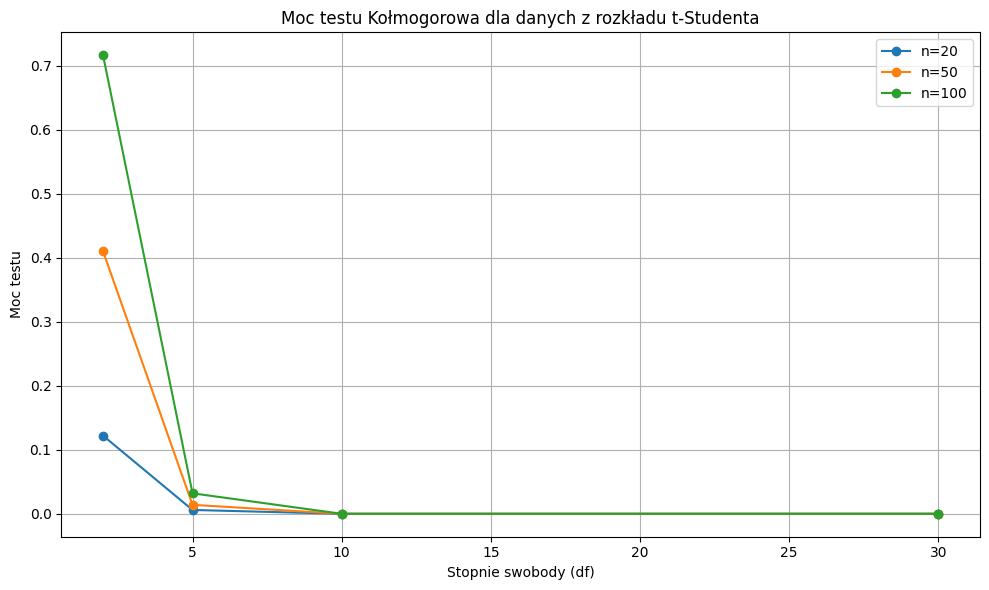

In [ ]:
##### TEST KOŁMOGOROWA #####

### 1) Rozkład t-Studenta ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, t

# Parametry
sample_sizes = [20, 50, 100]
t_dfs = [2, 5, 10, 30]
K = 500
alpha = 0.05

# Funkcja testu Kołmogorowa
def kolmogorov_test(data):
    mu = np.mean(data)
    sigma = np.std(data, ddof=1)
    _, p_value = kstest(data, 'norm', args=(mu, sigma))
    return p_value

# Symulacja mocy
def simulate_power():
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for df in t_dfs:
            rejections = 0
            for _ in range(K):
                sample = t.rvs(df, size=n)
                p = kolmogorov_test(sample)
                if p < alpha:
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Testy
results_classic = simulate_power()

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(t_dfs, results_classic[n], marker='o', label=f'n={n}')

plt.title('Moc testu Kołmogorowa dla danych z rozkładu t-Studenta')
plt.xlabel('Stopnie swobody (df)')
plt.ylabel('Moc testu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Im mniejszy df, tym większe odstępstwo od normalności -> większa moc testu
# Im większa próbka, tym większa czułość testu (wyższa moc)

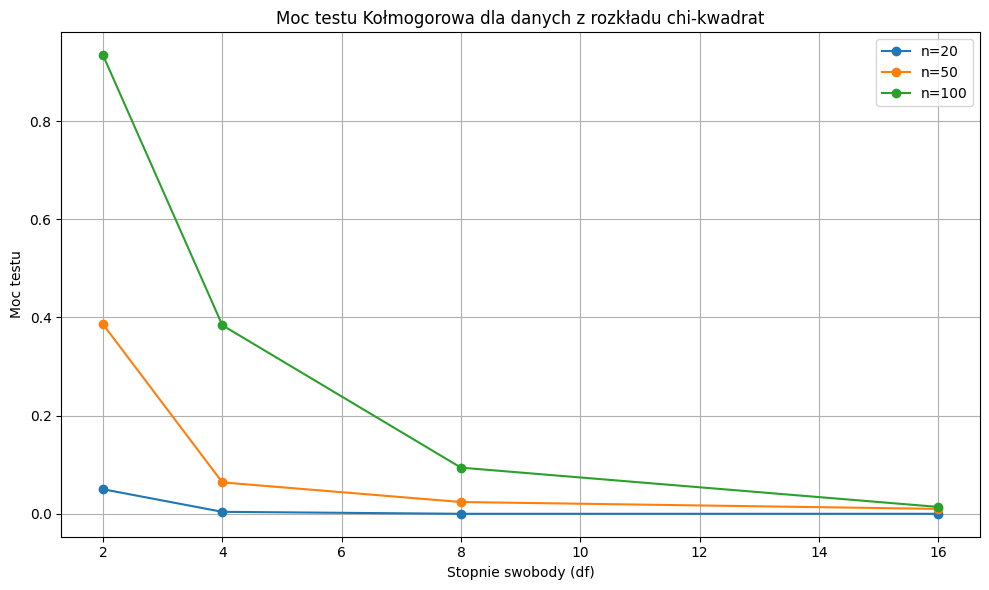

In [ ]:
### 2) Rozkład chi2 ###

from scipy.stats import chi2

# Parametry
sample_sizes = [20, 50, 100]
chi2_dfs = [2, 4, 8, 16]
K = 500
alpha = 0.05

# Funkcja testu Kołmogorowa
def kolmogorov_test(data):
    mu = np.mean(data)
    sigma = np.std(data, ddof=1)
    _, p_value = kstest(data, 'norm', args=(mu, sigma))
    return p_value

# Symulacja mocy testu Kołmogorowa dla rozkładu chi2 
def simulate_power_chi2(sample_sizes, dfs, K=500, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for df in dfs:
            rejections = 0
            for _ in range(K):
                data = chi2.rvs(df, size=n)
                p = kolmogorov_test(data)
                if p < alpha:
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Symulacje 
results_classic = simulate_power_chi2(sample_sizes, chi2_dfs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(chi2_dfs, results_classic[n], marker='o', label=f'n={n}')

plt.title('Moc testu Kołmogorowa dla danych z rozkładu chi-kwadrat')
plt.xlabel('Stopnie swobody (df)')
plt.ylabel('Moc testu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Im większa liczba df, tym bardziej rozkład zbliża się do normalnego -> moc testu spada
# Im większa liczność próbki, tym większa czułość testu (wyższa moc)

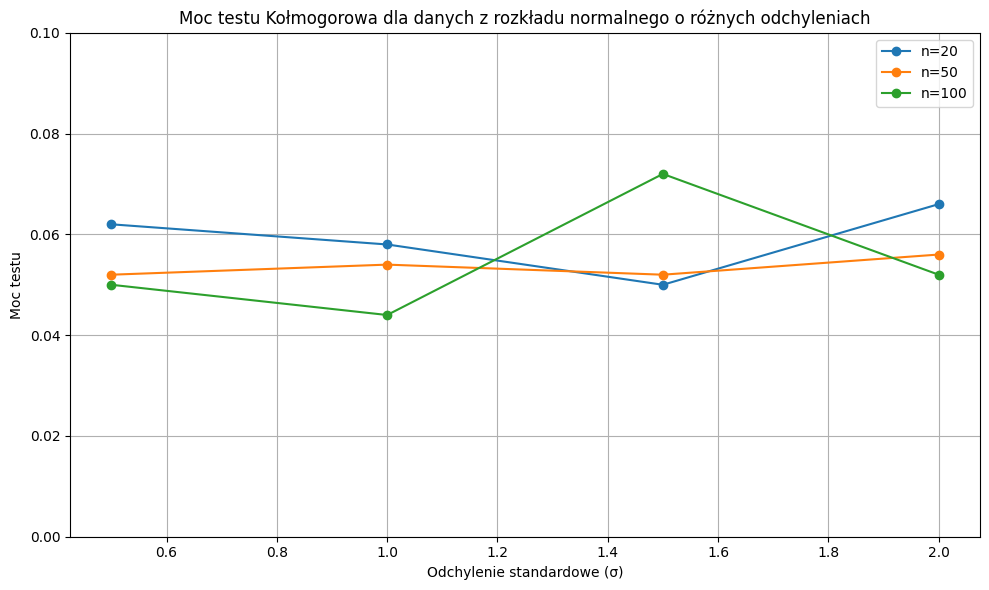

In [ ]:
### 3) Rozkłady normalne o różnych odchyleniach standardowych ###

from scipy.stats import norm # type: ignore

# Parametry
sample_sizes = [20, 50, 100]
std_devs = [0.5, 1.0, 1.5, 2.0]
K = 500
alpha = 0.05

# Test Kołmogorowa bez estymacji 
def kolmogorov_test_known_std(data, std):
    _, p_value = kstest(data, 'norm', args=(0, std))
    return p_value

# Symulacja mocy testu Kołmogorowa 
def simulate_power_normal_sigma_known(sample_sizes, std_devs, K=500, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for std in std_devs:
            rejections = 0
            for _ in range(K):
                data = norm.rvs(loc=0, scale=std, size=n)
                p = kolmogorov_test_known_std(data, std)
                if p < alpha:
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Uruchom symulacje
results_correct = simulate_power_normal_sigma_known(sample_sizes, std_devs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(std_devs, results_correct[n], marker='o', label=f'n={n}')

plt.title('Moc testu Kołmogorowa dla danych z rozkładu normalnego o różnych odchyleniach')
plt.xlabel('Odchylenie standardowe (σ)')
plt.ylabel('Moc testu')
plt.ylim(0, 0.1)  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Test nie powinien odrzucać danych z rozkładu normalnego — i nie odrzuca
# Zmiana odchylenia standardowego nie wpływa na moc testu
# Moc to około poziom istotności, co jest poprawnym wynikiem

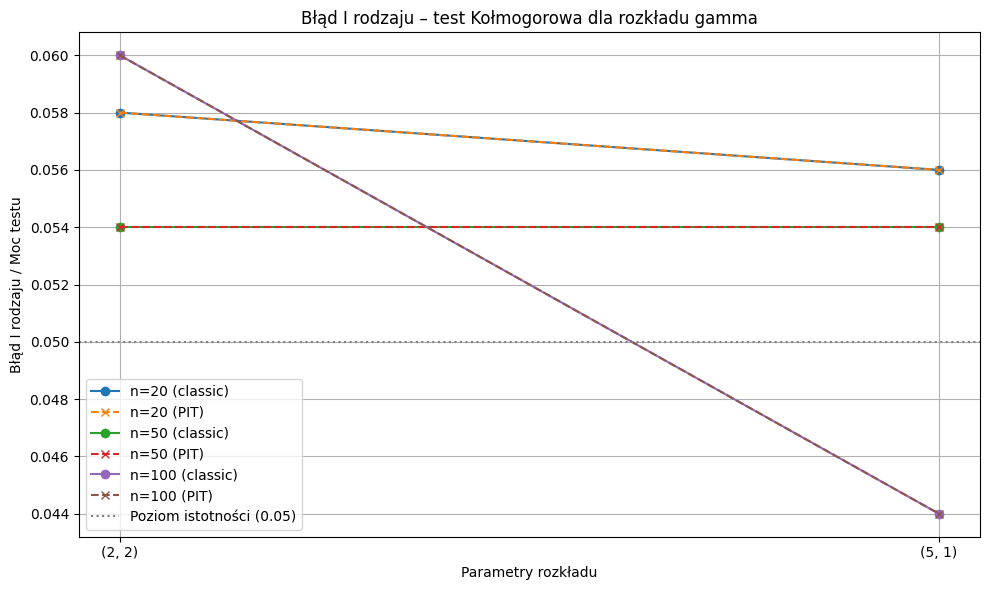

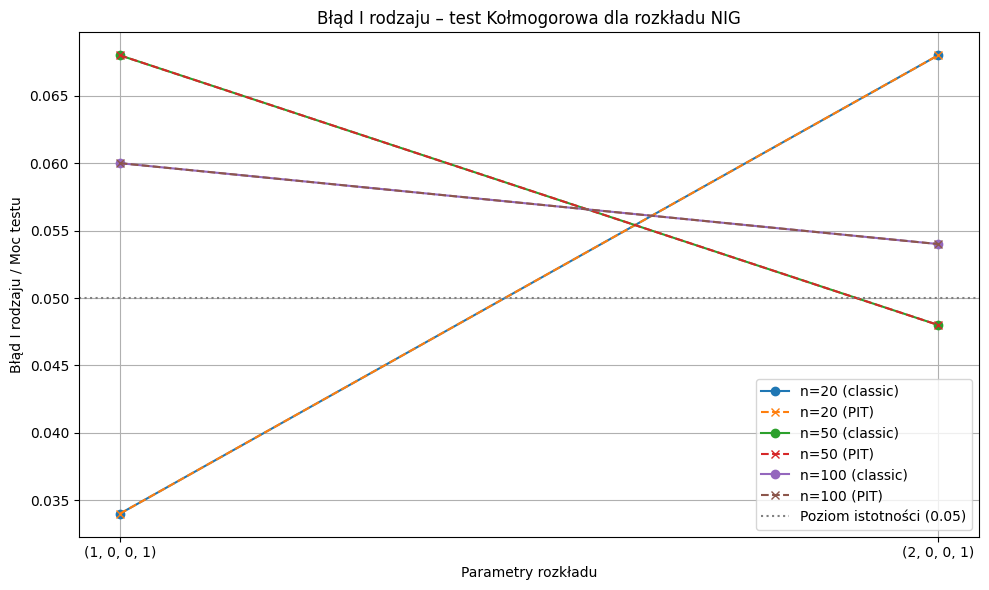

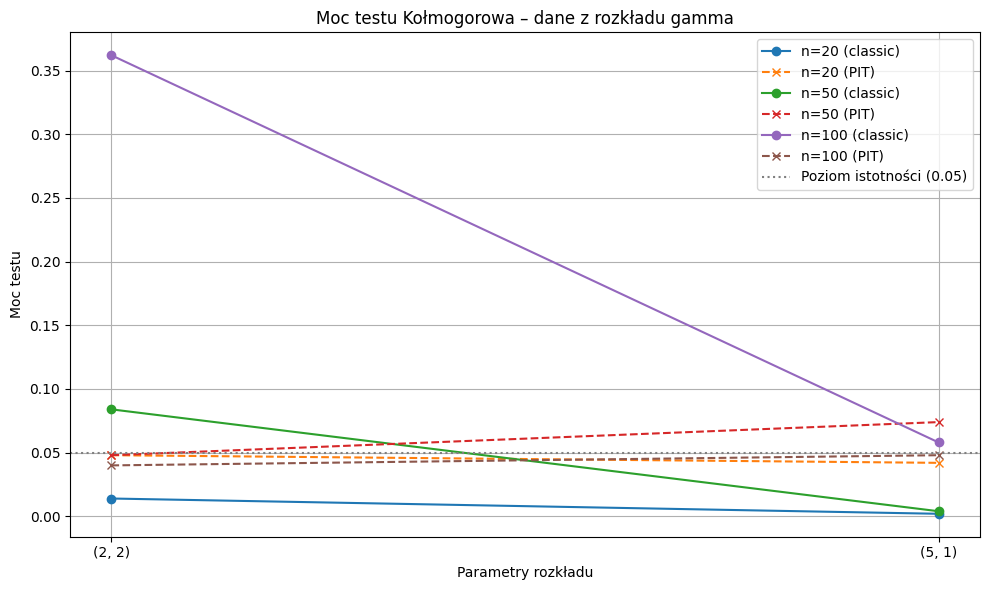

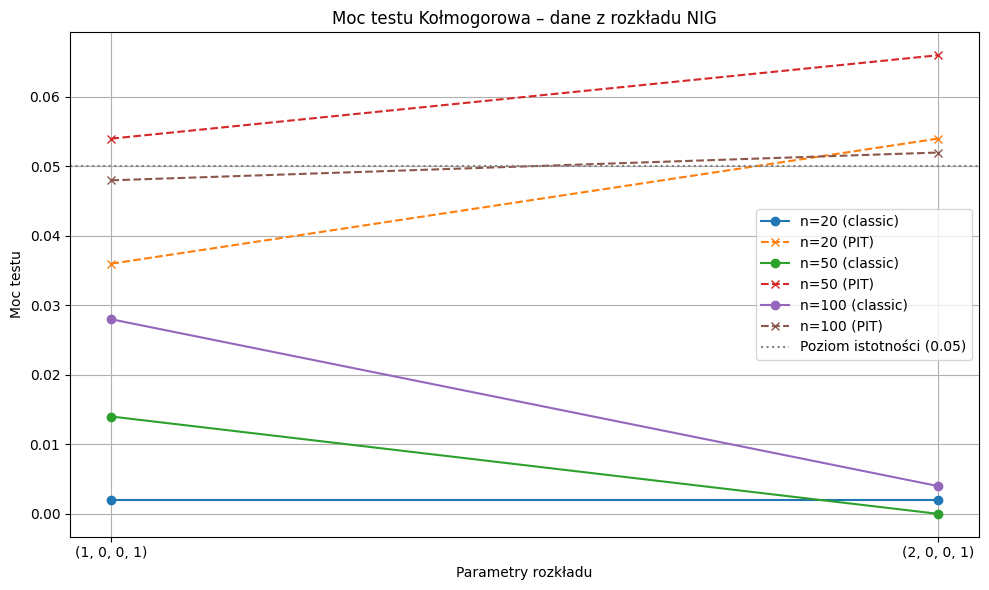

In [ ]:
### 4) Test gamma i NIG ###

from scipy.stats import gamma, norminvgauss # type: ignore

# Parametry
sample_sizes = [20, 50, 100]
K = 500
alpha = 0.05

# Parametry rozkładów
gamma_params = [(2, 2), (5, 1)]         
nig_params = [(1, 0, 0, 1), (2, 0, 0, 1)]  

# BŁĄD I RODZAJU
def error_type1(test_dist, dist_name, param_grid, sample_sizes, K=500, alpha=0.05):
    results_classic = {n: [] for n in sample_sizes}
    results_pit = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for params in param_grid:
            reject_c = 0
            reject_p = 0
            for _ in range(K):
                data = test_dist.rvs(*params, size=n)
                p1 = kstest(data, dist_name, args=params)[1]
                if p1 < alpha:
                    reject_c += 1
                uniform_data = test_dist.cdf(data, *params)
                p2 = kstest(uniform_data, 'uniform')[1]
                if p2 < alpha:
                    reject_p += 1
            results_classic[n].append(reject_c / K)
            results_pit[n].append(reject_p / K)
    return results_classic, results_pit

# Symulacje błędu I rodzaju
error_gamma_classic, error_gamma_pit = error_type1(gamma, 'gamma', gamma_params, sample_sizes, K, alpha)
error_nig_classic, error_nig_pit = error_type1(norminvgauss, 'norminvgauss', nig_params, sample_sizes, K, alpha)


# MOC TESTU 
def simulate_power_vs_normal(test_dist, dist_name, param_grid, sample_sizes, K=500, alpha=0.05):
    results_classic = {n: [] for n in sample_sizes}
    results_pit = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for params in param_grid:
            reject_c = 0
            reject_p = 0
            for _ in range(K):
                data = test_dist.rvs(*params, size=n)
                mu = np.mean(data)
                sigma = np.std(data, ddof=1)
                p1 = kstest(data, 'norm', args=(mu, sigma))[1]
                if p1 < alpha:
                    reject_c += 1
                u_data = test_dist.cdf(data, *params)
                p2 = kstest(u_data, 'uniform')[1]
                if p2 < alpha:
                    reject_p += 1
            results_classic[n].append(reject_c / K)
            results_pit[n].append(reject_p / K)
    return results_classic, results_pit

# Symulacje mocy testu 
power_gamma_classic, power_gamma_pit = simulate_power_vs_normal(gamma, 'gamma', gamma_params, sample_sizes, K, alpha)
power_nig_classic, power_nig_pit = simulate_power_vs_normal(norminvgauss, 'norminvgauss', nig_params, sample_sizes, K, alpha)

# WYKRESY
def plot_results(results_c, results_p, param_labels, sample_sizes, title, ylabel='Błąd I rodzaju / Moc testu'):
    plt.figure(figsize=(10, 6))
    for n in sample_sizes:
        plt.plot(param_labels, results_c[n], marker='o', label=f'n={n} (classic)')
        plt.plot(param_labels, results_p[n], marker='x', linestyle='--', label=f'n={n} (PIT)')
    plt.axhline(0.05, color='gray', linestyle='dotted', label='Poziom istotności (0.05)')
    plt.title(title)
    plt.xlabel('Parametry rozkładu')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Wykresy błędu I rodzaju
plot_results(error_gamma_classic, error_gamma_pit,
             param_labels=[str(p) for p in gamma_params],
             sample_sizes=sample_sizes,
             title='Błąd I rodzaju – test Kołmogorowa dla rozkładu gamma')

plot_results(error_nig_classic, error_nig_pit,
             param_labels=[str(p) for p in nig_params],
             sample_sizes=sample_sizes,
             title='Błąd I rodzaju – test Kołmogorowa dla rozkładu NIG')

# Wykresy mocy testu
plot_results(power_gamma_classic, power_gamma_pit,
             param_labels=[str(p) for p in gamma_params],
             sample_sizes=sample_sizes,
             title='Moc testu Kołmogorowa – dane z rozkładu gamma',
             ylabel='Moc testu')

plot_results(power_nig_classic, power_nig_pit,
             param_labels=[str(p) for p in nig_params],
             sample_sizes=sample_sizes,
             title='Moc testu Kołmogorowa – dane z rozkładu NIG',
             ylabel='Moc testu')


# Wnioski:
# Błąd I rodzaju:
# Zarówno dla gamma, jak i NIG, test Kołmogorowa (klasyczny i PIT) zachowuje poziom istotności (około 0.05).
# Dla większych prób błąd I rodzaju lekko spada, co jest zgodne z teorią.

# Moc testu:
# Dla danych z rozkładu gamma: test klasyczny z n=100 osiąga wysoką moc (około 36%) dla bardziej skośnych rozkładów (np. shape=2).
# PIT dla gamma ma niższą moc i jest mniej wrażliwy na zmiany parametrów – test klasyczny wypada lepiej.
# Dla danych z rozkładu NIG: test Kołmogorowa (zarówno klasyczny, jak i PIT) ma bardzo niską moc – nie wykrywa nienormalności.
# Wzrost liczności próbki poprawia moc tylko dla gamma, nie dla NIG.

# Dla rozkładów NIG potrzebne są silniejsze testy (np. Anderson-Darling, Shapiro-Wilk).

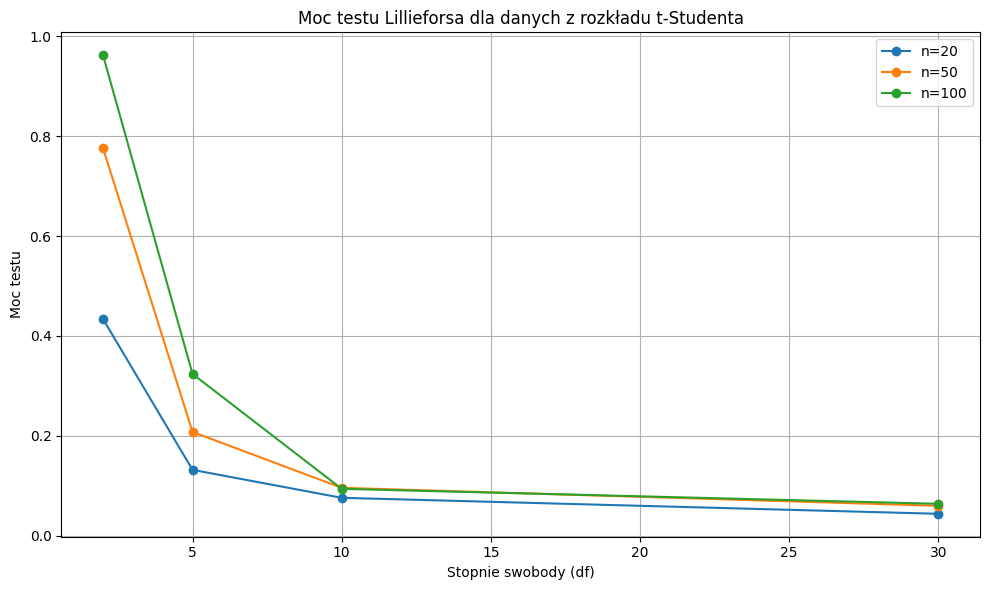

In [16]:
##### TEST LILLIEFORSA #####

### 1) Rozkład t-Studenta ###

from statsmodels.stats.diagnostic import lilliefors # type: ignore

# Parametry
sample_sizes = [20, 50, 100]
t_dfs = [2, 5, 10, 30]
K = 500
alpha = 0.05

# Funkcja: moc testu Lillieforsa dla rozkładu t-Studenta
def simulate_lilliefors_power_tstudent(sample_sizes, dfs, K=500, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for df in dfs:
            rejections = 0
            for _ in range(K):
                data = t.rvs(df, size=n)
                stat, p = lilliefors(data, dist='norm')
                if p < alpha:
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Uruchom testy
lilliefors_results = simulate_lilliefors_power_tstudent(sample_sizes, t_dfs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(t_dfs, lilliefors_results[n], marker='o', label=f'n={n}')

plt.title('Moc testu Lillieforsa dla danych z rozkładu t-Studenta')
plt.xlabel('Stopnie swobody (df)')
plt.ylabel('Moc testu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Wnioski:
# Im niższe df, tym silniejsze odstępstwo od normalności -> test ma wyższą moc.
# Przy df = 2, test wykrywa nienormalność bardzo skutecznie, szczególnie przy n=100 (moc około 0.97).
# Wraz ze wzrostem df rozkład t zbliża się do normalnego -> moc testu spada.
# Dla df = 30, test praktycznie nie odróżnia rozkładu t od normalnego (moc bliska 0).

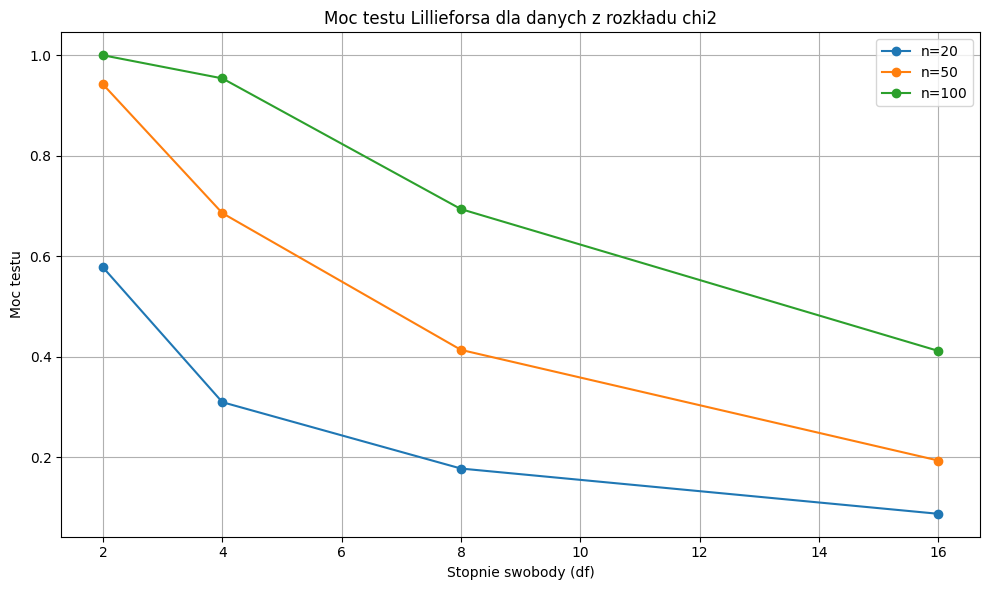

In [ ]:
### 2) Rozład chi2 ###

# Parametry
sample_sizes = [20, 50, 100]
chi2_dfs = [2, 4, 8, 16]
K = 500
alpha = 0.05

# Moc testu Lillieforsa dla rozkładu chi-kwadrat
def simulate_lilliefors_power_chi2(sample_sizes, dfs, K=500, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for df in dfs:
            rejections = 0
            for _ in range(K):
                data = chi2.rvs(df, size=n)
                stat, p = lilliefors(data, dist='norm')
                if p < alpha:
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Uruchom testy
lilliefors_results_chi2 = simulate_lilliefors_power_chi2(sample_sizes, chi2_dfs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(chi2_dfs, lilliefors_results_chi2[n], marker='o', label=f'n={n}')

plt.title('Moc testu Lillieforsa dla danych z rozkładu chi2')
plt.xlabel('Stopnie swobody (df)')
plt.ylabel('Moc testu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Dla n = 100 i df = 2–4 moc testu osiąga bardzo wysokie wartości (powyżej 0.95) — test skutecznie wykrywa nienormalność.
# Im większy df, tym bardziej rozkład chi2 przypomina normalny -> moc testu spada.
# Im większa próbka, tym większa zdolność testu do wykrycia odstępstw od normalności.
# Test Lillieforsa działa zgodnie z oczekiwaniami — jest czuły na skośność i rozciągnięcie rozkładu.

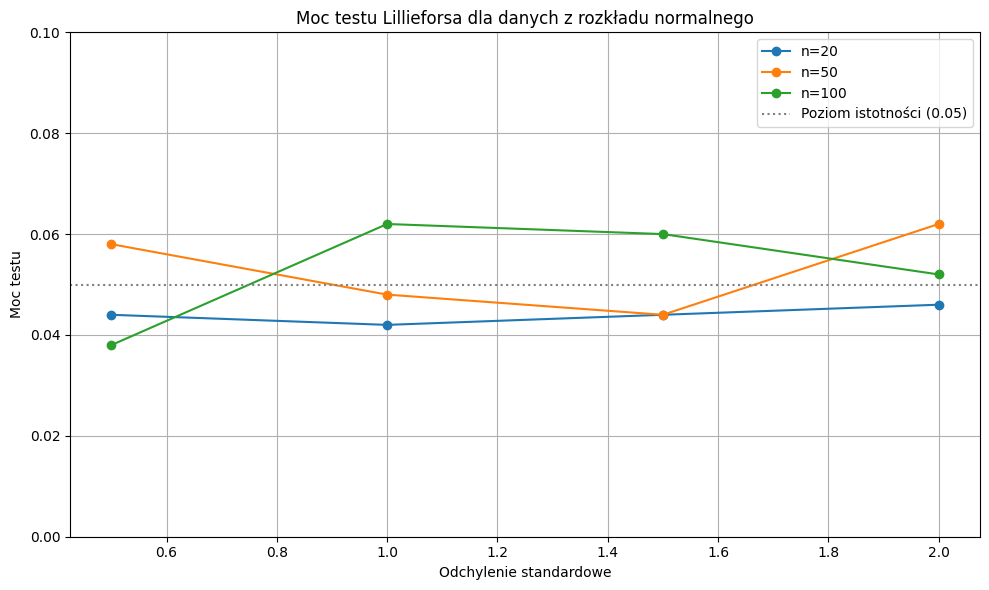

In [ ]:
### 3) Rozkłady normalne o różnych odchyleniach ###

# Parametry
sample_sizes = [20, 50, 100]
std_devs = [0.5, 1.0, 1.5, 2.0]
K = 500
alpha = 0.05

# Funkcja: moc testu Lillieforsa dla danych z rozkładu normalnego 
def simulate_lilliefors_power_normal_std(sample_sizes, std_devs, K=500, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for std in std_devs:
            rejections = 0
            for _ in range(K):
                data = norm.rvs(loc=0, scale=std, size=n)
                stat, p = lilliefors(data, dist='norm')
                if p < alpha:
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Uruchom testy
lilliefors_power_normal_std = simulate_lilliefors_power_normal_std(sample_sizes, std_devs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(std_devs, lilliefors_power_normal_std[n], marker='o', label=f'n={n}')

plt.title('Moc testu Lillieforsa dla danych z rozkładu normalnego')
plt.xlabel('Odchylenie standardowe')
plt.ylabel('Moc testu')
plt.ylim(0.0, 0.1)  
plt.axhline(0.05, color='gray', linestyle='dotted', label='Poziom istotności (0.05)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Test Lillieforsa zachowuje się zgodnie z oczekiwaniami
# Moc testu oscyluje wokół poziomu istotności (0.05).
# Wartość odchylenia standardowego nie wpływa istotnie na wynik testu — test jest odporny na skalowanie.
# Dla większych prób (n=100) zdarzają się nieco częstsze odrzucenia H₀ (około 0.06), co może wynikać z większej czułości testu.
# Ogólnie test jest stabilny i nie wykazuje tendencji do nadmiernego odrzucania hipotezy zerowej.


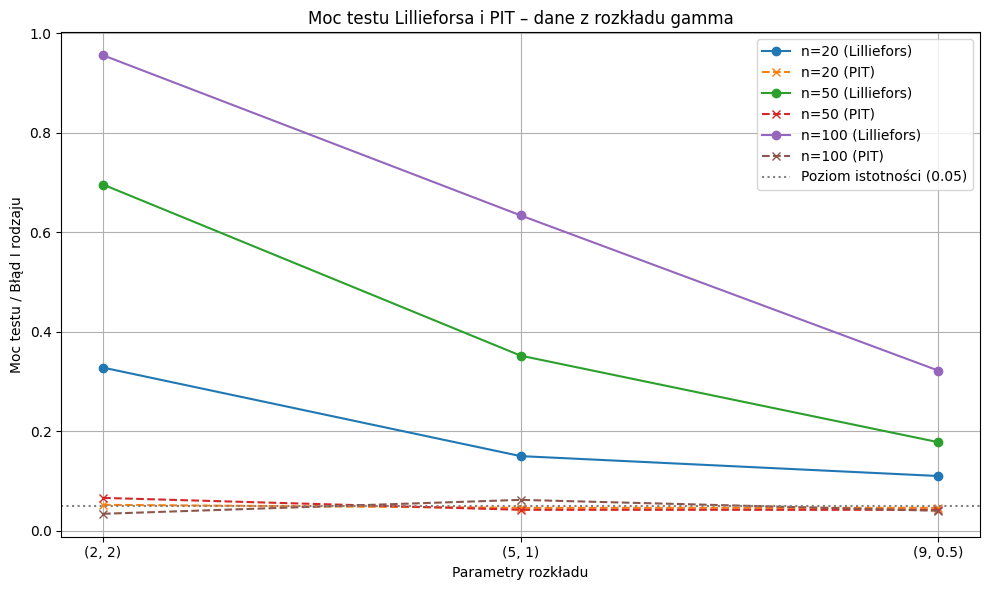

In [ ]:
### 4) Rozkład gamma ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, gamma, norm
from statsmodels.stats.diagnostic import lilliefors

# Parametry
sample_sizes = [20, 50, 100]
gamma_params = [(2, 2), (5, 1), (9, 0.5)]
K = 500
alpha = 0.05

# Moc testu Lillieforsa 
def simulate_lilliefors_power_custom(dist, param_grid, sample_sizes, K=100, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for params in param_grid:
            rejections = 0
            for _ in range(K):
                data = dist.rvs(*params, size=n)
                stat, p = lilliefors(data, dist='norm')
                if p < alpha:
                    rejections += 1
            results[n].append(rejections / K)
    return results

# PIT
def simulate_pit_error_custom(dist, param_grid, sample_sizes, K=100, alpha=0.05):
    results_pit = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for params in param_grid:
            rejections = 0
            for _ in range(K):
                data = dist.rvs(*params, size=n)
                u_data = dist.cdf(data, *params)
                _, p = kstest(u_data, 'uniform')
                if p < alpha:
                    rejections += 1
            results_pit[n].append(rejections / K)
    return results_pit

# Symulacje 
lilliefors_gamma_power = simulate_lilliefors_power_custom(gamma, gamma_params, sample_sizes, K, alpha)
pit_error_gamma = simulate_pit_error_custom(gamma, gamma_params, sample_sizes, K, alpha)

# Wykres mocy testu + PIT
def plot_lilliefors_vs_pit(power_results, pit_results, param_labels, sample_sizes, title, ylabel='Moc testu / Błąd I rodzaju'):
    plt.figure(figsize=(10, 6))
    for n in sample_sizes:
        plt.plot(param_labels, power_results[n], marker='o', label=f'n={n} (Lilliefors)')
        plt.plot(param_labels, pit_results[n], marker='x', linestyle='--', label=f'n={n} (PIT)')
    plt.axhline(0.05, color='gray', linestyle='dotted', label='Poziom istotności (0.05)')
    plt.title(title)
    plt.xlabel('Parametry rozkładu')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_lilliefors_vs_pit(
    lilliefors_gamma_power,
    pit_error_gamma,
    param_labels=[str(p) for p in gamma_params],
    sample_sizes=sample_sizes,
    title='Moc testu Lillieforsa i PIT – dane z rozkładu gamma'
)


# Wnioski:
# Dane pochodzą z rozkładu gamma, więc "normalność" jest fałszywa – test powinien ją odrzucać (czyli mieć wysoką moc).
# Test Lillieforsa:
#    - Moc testu rośnie wyraźnie wraz z liczebnością próbki (n).
#    - Najwyższa moc dla n=100 i shape=2 (około 95%), gdzie rozkład gamma jest najbardziej skośny.
#    - Im większy shape (czyli bardziej "symetryczny” gamma), tym trudniej odróżnić od normalnego – moc testu spada.
# PIT:
#    - Daje bardzo niski odsetek odrzuceń (około 5–6%) – czyli zachowuje się jak przy błędzie I rodzaju.
#    - Nie wykrywa nienormalności nawet przy dużych próbkach i silnej skośności.
#    - Działa poprawnie tylko przy danych z rozkładu zgodnego z założeniem (czyli tu nie spełnia celu).



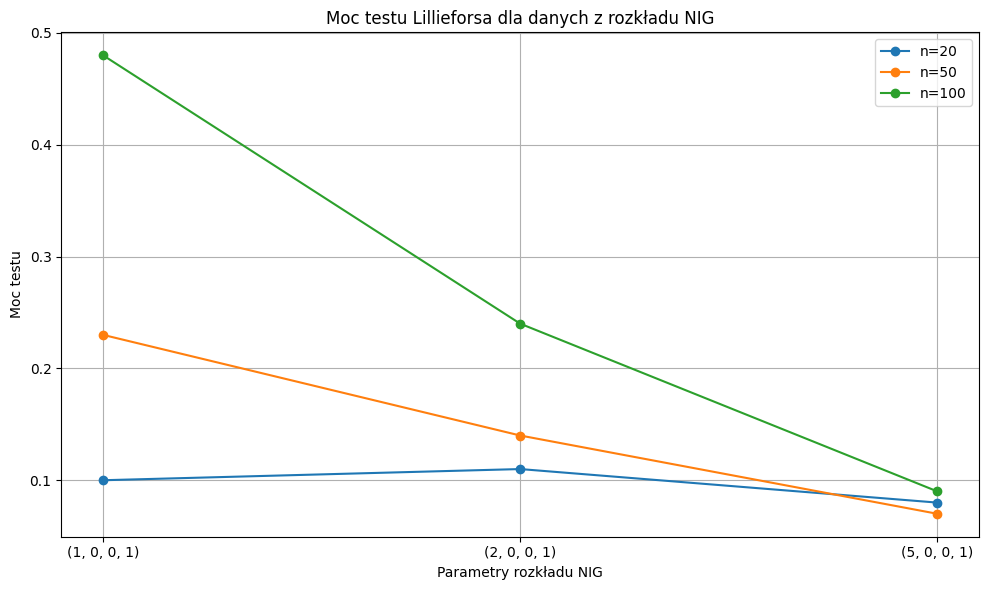

In [4]:
### 5) Rozkład NIG ###

from scipy.stats import norminvgauss

# Parametry
sample_sizes = [20, 50, 100]
nig_params = [(1, 0, 0, 1), (2, 0, 0, 1), (5, 0, 0, 1)]  # (alpha, beta, loc, scale)
K = 100
alpha = 0.05

# Moc testu Lillieforsa dla danych z rozkładu NIG
def simulate_lilliefors_power_nig(sample_sizes, nig_param_grid, K=100, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for params in nig_param_grid:
            rejections = 0
            for _ in range(K):
                data = norminvgauss.rvs(*params, size=n)
                stat, p = lilliefors(data, dist='norm')
                if p < alpha:
                    rejections += 1
            results[n].append(rejections / K)
    return results

# Symulacja
lilliefors_nig_power = simulate_lilliefors_power_nig(sample_sizes, nig_params, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot([str(p) for p in nig_params], lilliefors_nig_power[n], marker='o', label=f'n={n}')
plt.title('Moc testu Lillieforsa dla danych z rozkładu NIG')
plt.xlabel('Parametry rozkładu NIG')
plt.ylabel('Moc testu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Wnioski:
# Test Lillieforsa wykrywa nienormalność rozkładu NIG, ale jego moc jest umiarkowana, zwłaszcza przy mniejszych próbkach.
# Dla n=100, moc testu wzrasta, ale nadal pozostaje w zakresie 0.2–0.45, co oznacza, że test nie zawsze odrzuca fałszywą H0.
# Parametr alfa (większa wartość = bardziej rozciągnięte ogony) wpływa na wzrost mocy, ale nie tak silnie jak w przypadku gamma.
# W praktyce: test Lillieforsa może nie być wystarczająco czuły dla NIG, szczególnie przy małych próbkach i łagodnych odstępstwach od normalności.


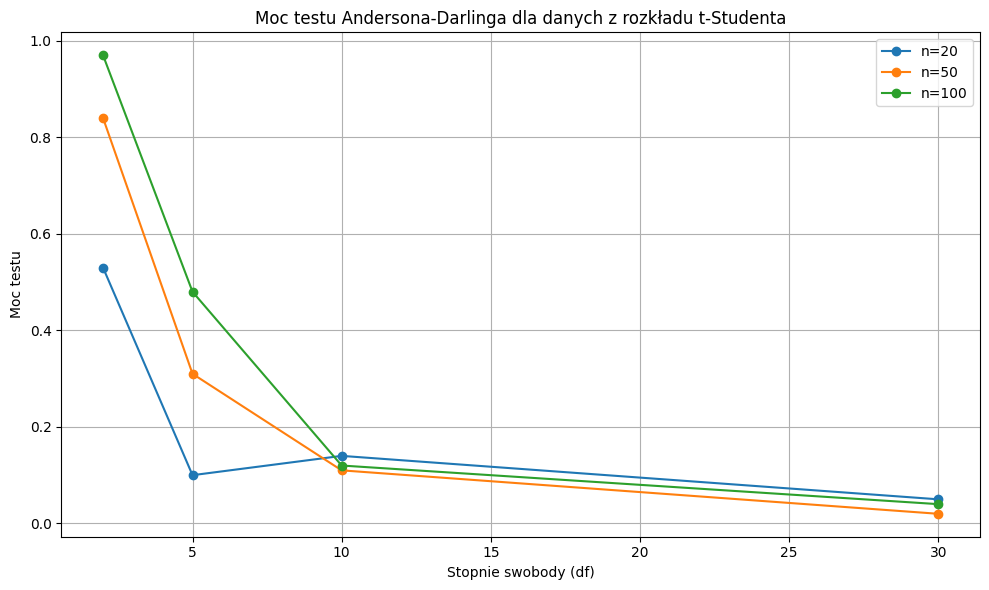

In [ ]:
##### TEST ANDERSONA-DARLINGA #####

# 1) Rozkład t-STudenta

from scipy.stats import t, anderson

# Parametry
sample_sizes = [20, 50, 100]
t_dfs = [2, 5, 10, 30]
K = 100  # liczba symulacji
alpha = 0.05

# Moc testu Andersona-Darlinga dla danych z t-Studenta
def simulate_ad_power_tstudent(sample_sizes, dfs, K=100, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for df in dfs:
            rejections = 0
            for _ in range(K):
                data = t.rvs(df, size=n)
                result = anderson(data, dist='norm')
                # Porównanie ze statystyką krytyczną dla poziomu 5%
                if result.statistic > result.critical_values[2]:
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Symulacja
ad_results_t = simulate_ad_power_tstudent(sample_sizes, t_dfs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(t_dfs, ad_results_t[n], marker='o', label=f'n={n}')
plt.title('Moc testu Andersona-Darlinga dla danych z rozkładu t-Studenta')
plt.xlabel('Stopnie swobody (df)')
plt.ylabel('Moc testu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Dla małych df test ma wysoką moc (dobrze wykrywa odstępstwa od normalności),
# Dla dużych df, test traci moc (rozkład t około normalny),
# Test AD dobrze działa nawet przy mniejszych próbach.

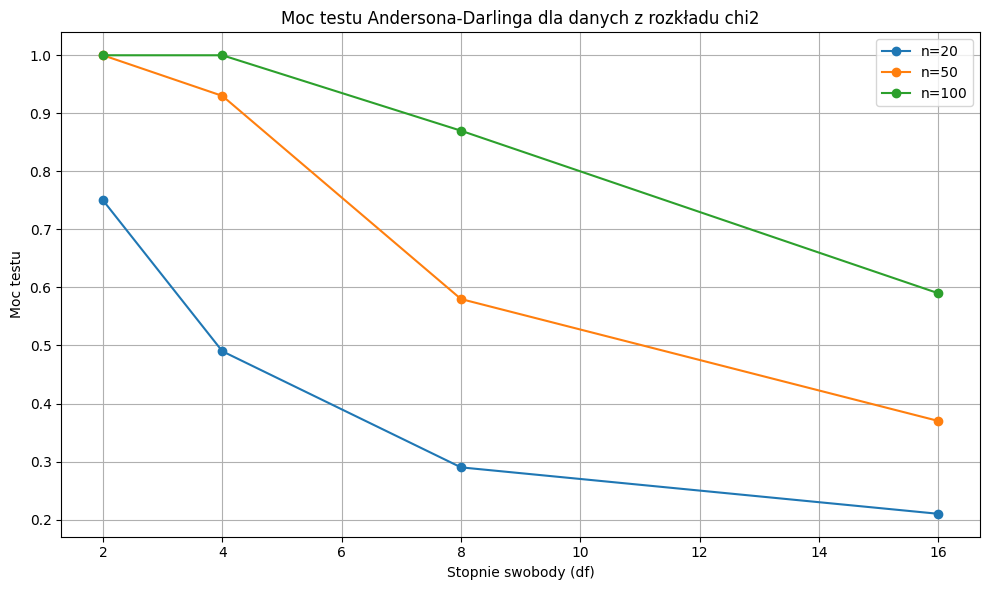

In [6]:
### 2) Rozkład chi2 ###

from scipy.stats import chi2

# Parametry
sample_sizes = [20, 50, 100]
chi2_dfs = [2, 4, 8, 16]
K = 100
alpha = 0.05

# Moc testu Andersona-Darlinga dla danych z rozkładu chi2
def simulate_ad_power_chi2(sample_sizes, dfs, K=100, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for df in dfs:
            rejections = 0
            for _ in range(K):
                data = chi2.rvs(df, size=n)
                result = anderson(data, dist='norm')
                if result.statistic > result.critical_values[2]:  # Poziom istotności 5%
                    rejections += 1
            power = rejections / K
            results[n].append(power)
    return results

# Symulacja
ad_results_chi2 = simulate_ad_power_chi2(sample_sizes, chi2_dfs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(chi2_dfs, ad_results_chi2[n], marker='o', label=f'n={n}')
plt.title('Moc testu Andersona-Darlinga dla danych z rozkładu chi2')
plt.xlabel('Stopnie swobody (df)')
plt.ylabel('Moc testu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Test bardzo dobrze wykrywa nienormalność danych z rozkładu chi2.
# Im mniejsze df, tym bardziej skośny i odległy od normalnego rozkład -> moc testu wzrasta.
# Dla df=2 i n=100 moc jest bliska 1 — test niemal zawsze odrzuca fałszywą H0.
# Dla df=16, gdzie rozkład chi2 zaczyna przypominać normalny, moc testu spada (ok. 0.4–0.5 przy n=20).
# Test Andersona-Darlinga dobrze radzi sobie z wykrywaniem nienormalności nawet dla mniejszych prób.

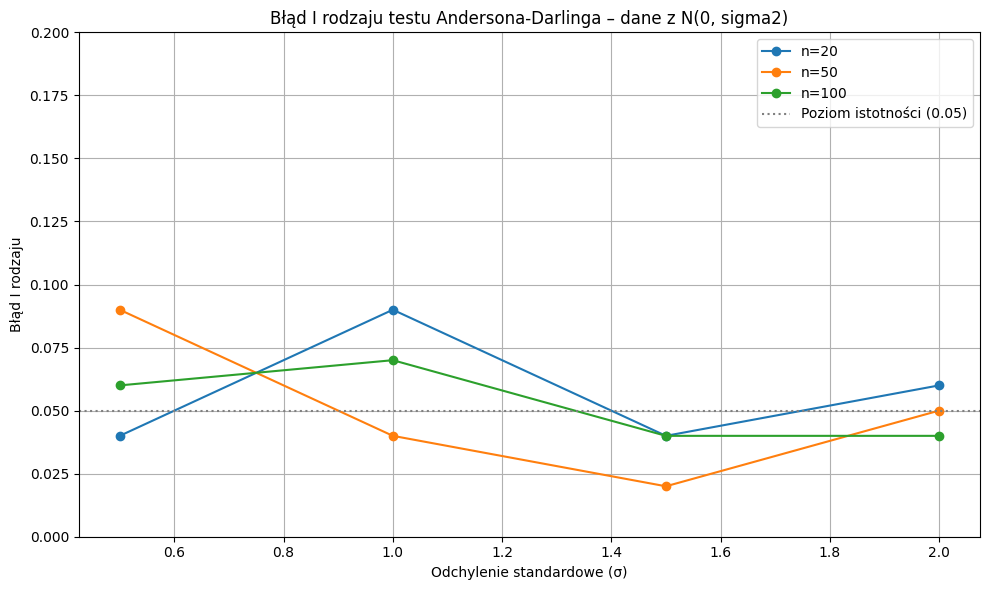

In [8]:
### 3) Rozkłady normalne z różnym odchyleniem ###

from scipy.stats import norm, anderson

# Parametry
sample_sizes = [20, 50, 100]
std_devs = [0.5, 1.0, 1.5, 2.0]
K = 100
alpha = 0.05

# Błąd I rodzaju testu Andersona-Darlinga dla N(0, sigma2)
def simulate_ad_type1_error_normal(sample_sizes, std_devs, K=100, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for std in std_devs:
            rejections = 0
            for _ in range(K):
                data = norm.rvs(loc=0, scale=std, size=n)
                result = anderson(data, dist='norm')
                if result.statistic > result.critical_values[2]:
                    rejections += 1
            error_rate = rejections / K
            results[n].append(error_rate)
    return results

# Symulacja
ad_type1_results = simulate_ad_type1_error_normal(sample_sizes, std_devs, K=K, alpha=alpha)

# Wykres
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot(std_devs, ad_type1_results[n], marker='o', label=f'n={n}')
plt.axhline(0.05, color='gray', linestyle='dotted', label='Poziom istotności (0.05)')
plt.title('Błąd I rodzaju testu Andersona-Darlinga – dane z N(0, sigma2)')
plt.xlabel('Odchylenie standardowe (σ)')
plt.ylabel('Błąd I rodzaju')
plt.ylim(0.0, 0.2) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

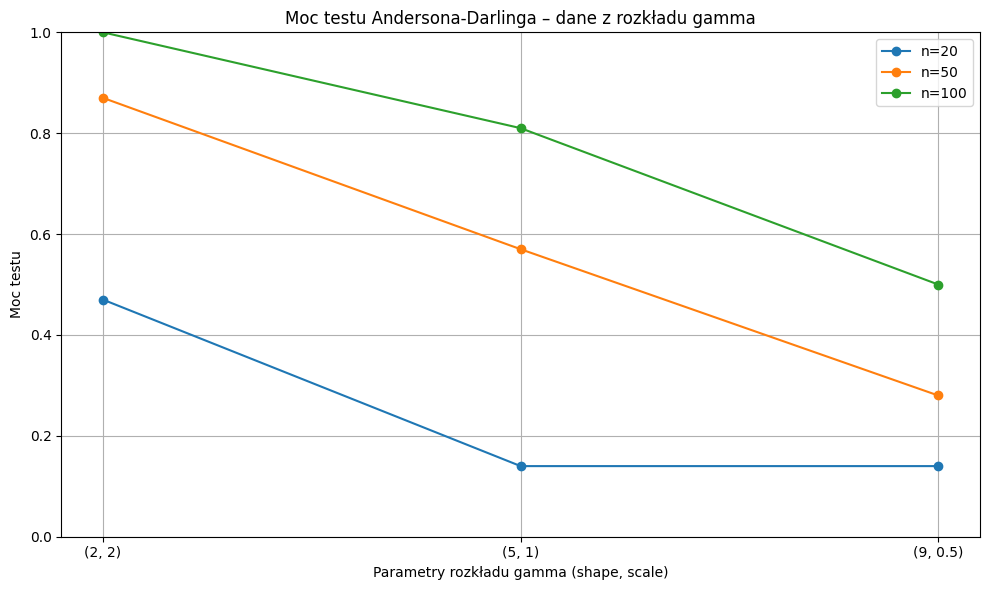

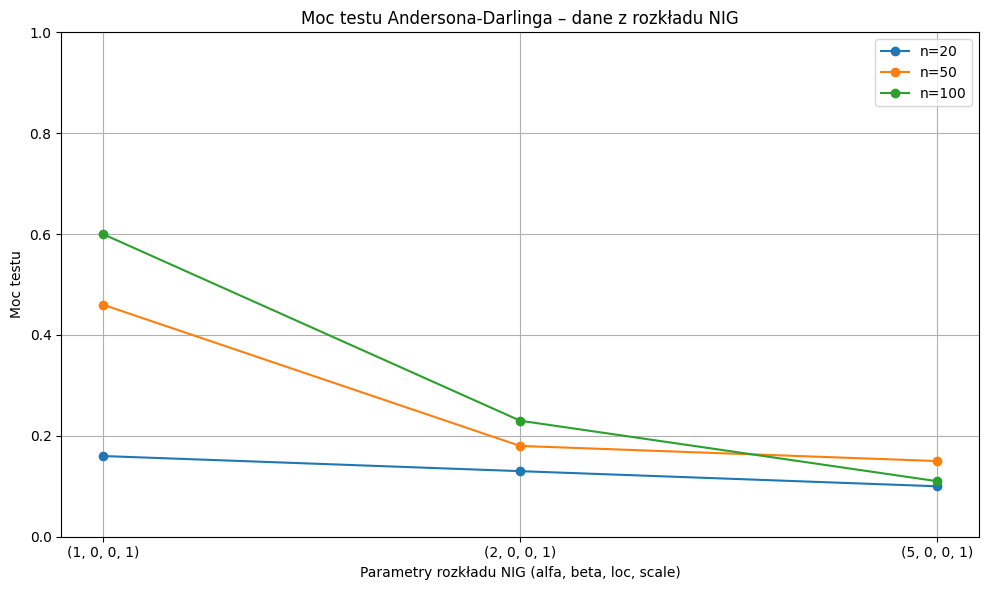

In [9]:
### 4) Rozkłady gamma i NIG ###

# Parametry
sample_sizes = [20, 50, 100]
gamma_params = [(2, 2), (5, 1), (9, 0.5)]
nig_params = [(1, 0, 0, 1), (2, 0, 0, 1), (5, 0, 0, 1)]
K = 100
alpha = 0.05

# Moc testu Andersona-Darlinga dla dowolnego rozkładu
def simulate_ad_power_custom(dist, param_grid, sample_sizes, K=100, alpha=0.05):
    results = {n: [] for n in sample_sizes}
    for n in sample_sizes:
        for params in param_grid:
            rejections = 0
            for _ in range(K):
                data = dist.rvs(*params, size=n)
                result = anderson(data, dist='norm')
                if result.statistic > result.critical_values[2]:
                    rejections += 1
            results[n].append(rejections / K)
    return results

# Symulacja mocy
ad_power_gamma = simulate_ad_power_custom(gamma, gamma_params, sample_sizes, K=K, alpha=alpha)
ad_power_nig = simulate_ad_power_custom(norminvgauss, nig_params, sample_sizes, K=K, alpha=alpha)

# Wykres: GAMMA
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot([str(p) for p in gamma_params], ad_power_gamma[n], marker='o', label=f'n={n}')
plt.title('Moc testu Andersona-Darlinga – dane z rozkładu gamma')
plt.xlabel('Parametry rozkładu gamma (shape, scale)')
plt.ylabel('Moc testu')
plt.ylim(0.0, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wykres: NIG
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    plt.plot([str(p) for p in nig_params], ad_power_nig[n], marker='o', label=f'n={n}')
plt.title('Moc testu Andersona-Darlinga – dane z rozkładu NIG')
plt.xlabel('Parametry rozkładu NIG (alfa, beta, loc, scale)')
plt.ylabel('Moc testu')
plt.ylim(0.0, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wnioski:
# Test AD skutecznie wykrywa nienormalność danych z rozkładów gamma i NIG.
# Gamma:
#    - Największa moc dla silnie skośnych rozkładów (np. gamma(2,2)).
#    - Wraz ze wzrostem liczebności próby moc testu istotnie rośnie (dla n=100 blisko 1).
# NIG:
#    - Moc testu również rośnie z licznością próbki, ale jest niższa niż dla gamma.
#    - Im większy parametr alfa (rozciągnięcie ogonów), tym lepiej test wykrywa odstępstwa od normalności.
# Test AD jest bardzo czuły na asymetrię i ciężkie ogony – dobrze sprawdza się przy danych, które tylko z pozoru przypominają normalne.